In [1]:
import matplotlib.pyplot as plt
from welly import Well
import numpy as np

In [2]:
w = Well.from_las('d:/data/1021417_______00.LAS')
w.data.keys()

C:\ProgramData\Anaconda3\lib\site-packages\welly\well.py:193: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


dict_keys(['GRGM', 'DT35', 'DEN', 'GR'])

In [3]:
#Loading the log files 
KB = w.location.ekb
SON = 'DT35'
STEP = w.data[SON].step
DEPTH = w.data[SON].basis


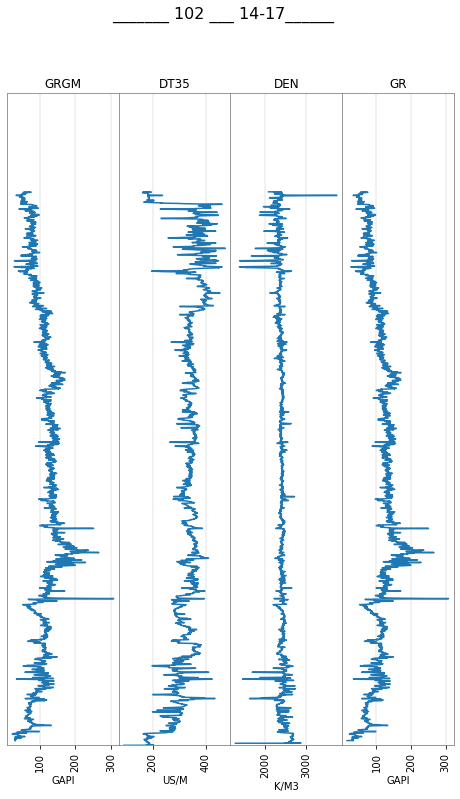

In [4]:
w.plot()

In [5]:
# create a td pair for the current synthetic 
# How do we determine what pair to pick? 
# TD pairs from synth tie
td = {'ss':[45.1,-65.3,-172.5,-290],'t':[605,687,759,834]} # ss = subsurface depth; t = time 

mlst = [] # calculating true depth ????
for value in td['ss']:
    mlst.append(KB-value)

td['d'] = mlst
td

{'ss': [45.1, -65.3, -172.5, -290],
 't': [605, 687, 759, 834],
 'd': [668.3, 778.6999999999999, 885.9, 1003.4]}

In [6]:
t = np.cumsum(w.data[SON]* STEP*2/10**3) # step = dx depth step - cumulative sum of dt for each step

Text(0, 0.5, 'depth')

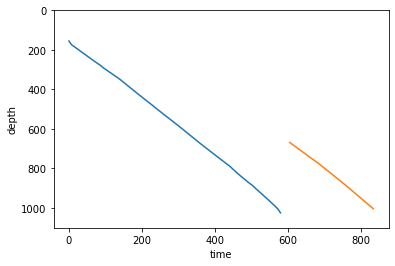

In [7]:
plt.plot(t,DEPTH) # time depth relationship from well log - cumulative sum 
plt.plot(td['t'],td['d']) # desired time depth pair - will be used to shift the data 
plt.ylim(1100,0)
plt.xlabel('time')
plt.ylabel('depth')

In [9]:
#shift to align first t-d pair - bulk shift - should change replacement velocity instead so the datum stays the same 

indx = np.where((DEPTH>td['d'][0]-STEP/2) & (DEPTH<td['d'][0]+STEP/2))
bs = t[indx] - td['t'][0]
t -= bs


Text(0, 0.5, 'depth')

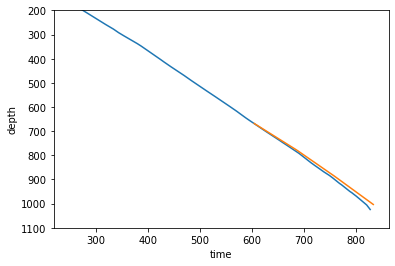

In [10]:
plt.plot(t,DEPTH)
plt.plot(td['t'],td['d'])
plt.ylim(1100,200)
plt.xlabel('time')
plt.ylabel('depth')

82 77.08099178001748
1.0638160992274326
72 69.23382670001502
1.0399540720458889
75 68.97692724001524
1.0873201083461808


(1100.0, 0.0)

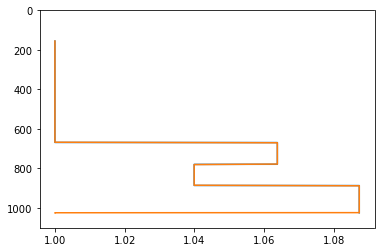

In [22]:
#calc shift for each layer

correction = np.ones(t.shape[0]) # create an empty correction the same size as the time vector 

i = 1
for d in td['d'][1:]: # for each depth in the time depth pair 
   
    td_time = td['t'][i]-td["t"][i-1] # calculate the timedepth time difference 

#log time = logtime at d1-d0
    # determine where depth is greater than the 
    indxd0 =  np.where((DEPTH>td['d'][i-1]-STEP/2) & (DEPTH<td['d'][i-1]+STEP/2))
    indxd1 =  np.where((DEPTH>td['d'][i]-STEP/2) & (DEPTH<td['d'][i]+STEP/2))
    
#     print(indxd0,indxd1)
    indxd0 = int(indxd0[0])
    indxd1 = int(indxd1[0])

    t_time = [t[indxd1] - t[indxd0]][0]
    print(td_time,t_time)

    layer_corr = td_time/t_time
    i += 1
    
    print(layer_corr)
    correction[indxd0:indxd1] = layer_corr

correction[indxd1:] = layer_corr

plt.plot(correction,DEPTH)
# plt.plot(w.data['DTP'],depth)
# plt.plot(w.data['DTP']*correction,depth)


#moving average
ma_w = 21
ma_h = ma_w//2
corr_ma = np.zeros(correction.shape[0])
for i in range(ma_h,correction[ma_h:].shape[0]):
#     print(i)
    corr_ma[i] = np.average(correction[i-ma_h:i+ma_h+1])
corr_ma[0:ma_h] = corr_ma[ma_h+1]
corr_ma[-ma_h:] = corr_ma[ma_h-1]  

plt.plot(corr_ma,DEPTH)

plt.ylim(1100,0)


(1100.0, 200.0)

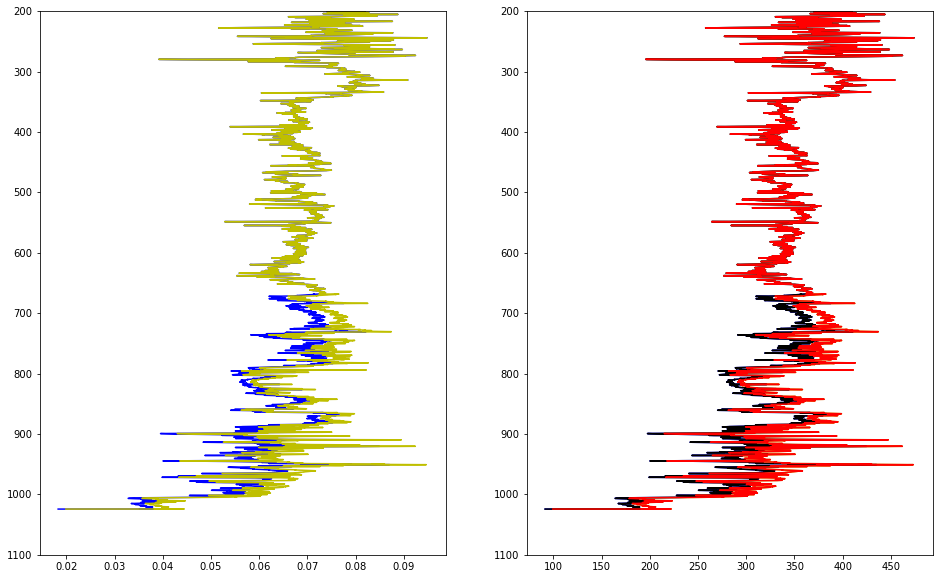

In [12]:
t_step = t[1:] - t[0:-1]

fig, ax = plt.subplots(figsize=(16,10))

plt.subplot(121)
plt.plot(t_step,DEPTH[1:],c='b')
plt.plot(t_step*correction[1:],DEPTH[1:],c='y')
plt.ylim(1100,200)

plt.subplot(122)
t_step = t[1:] - t[0:-1]
plt.plot(t_step/STEP/2*10**3,DEPTH[1:],c='b')
plt.plot(t_step*correction[1:]/STEP/2*10**3,DEPTH[1:],c='y')
plt.plot(w.data[SON],DEPTH,c='k')
plt.plot(w.data[SON]*correction,DEPTH,c='r')
plt.ylim(1100,200)

In [13]:
#export corrected sonic
w.data['DT_corr'] = w.data[SON]*correction
w.to_las("..\..\out.las")


Text(0, 0.5, 'depth')

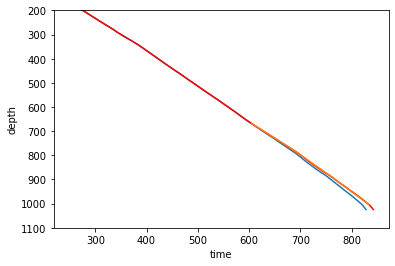

In [14]:
t_corr = np.cumsum(t_step*correction[1:]) - bs

plt.plot(t,DEPTH)
plt.plot(t_corr,DEPTH[1:],c='r')
plt.plot(td['t'],td['d'])
plt.ylim(1100,200)
plt.xlabel('time')
plt.ylabel('depth')

In [ ]:
ma_w = 5
ma_h = 2
corr_ma = np.zeros(correction.shape[0])
for i in range(2,correction[2:].shape[0]):
#     print(i)
    corr_ma[i] = np.average(correction[i-ma_h:i+ma_h+1])
corr_ma[0:2] = corr_ma[3]
corr_ma[-2:] = corr_ma[-3]  

plt.plot(corr_ma)

In [ ]:
t_step = t[1:] - t[0:-1]
plt.plot(t_step/STEP/2*10**3,depth[1:],c='b')
plt.plot(t_step*correction[1:]/STEP/2*10**3,depth[1:],c='y')
plt.plot(w.data['DTP'],w.data['DTP'].basis,c='k')
plt.plot(w.data['DTP']*corr_ma,w.data['DTP'].basis,c='r')
plt.ylim(1100,200)

In [17]:
ma_w//2

2

## 

In [18]:
5//2

2

In [19]:
9//2

4

In [1]:
print(STEP)

NameError: name 'STEP' is not defined